In [1]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np

In [2]:
words = open('names.txt','r').read().splitlines()
words[:3]

['emma', 'olivia', 'ava']

In [3]:
min([len(w) for w in words]), max([len(w) for w in words])

(2, 15)

In [4]:
len(words)

32033

In [5]:
counts_dict = {}
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs[:-1], chs[1:]):
        # print(f'{ch1} - {ch2}')
        bigram = (ch1, ch2)
        counts_dict[bigram] = counts_dict.get(bigram, 0) + 1

In [6]:
sorted(counts_dict.items(), key=lambda kv: -kv[1])[:10]

[(('n', '.'), 6763),
 (('a', '.'), 6640),
 (('a', 'n'), 5438),
 (('.', 'a'), 4410),
 (('e', '.'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('.', 'k'), 2963)]

In [7]:
vocab = sorted(list(set(''.join(words))) + ['.'])
vocab_size = len(vocab)

stoi = {ch: i for i,ch in enumerate(vocab)}

itos = {i: ch for ch,i in stoi.items()}

In [8]:
N = torch.ones((vocab_size, vocab_size), dtype=torch.int32)

In [9]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs[:-1], chs[1:]):
        # print(f'{ch1} - {ch2}')
        ix1, ix2 = stoi[ch1], stoi[ch2]
        N[ix1, ix2] += 1

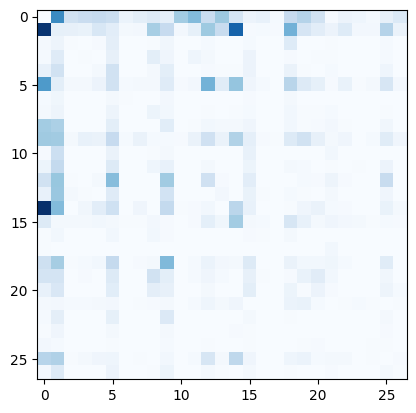

In [10]:
plt.imshow(N, cmap='Blues')

In [11]:
annot = np.empty_like(N, dtype=object)
for i in range(vocab_size):
    for j in range(vocab_size):
        annot[i,j] = f'{itos[i]}-{itos[j]}\n{N[i,j]}'

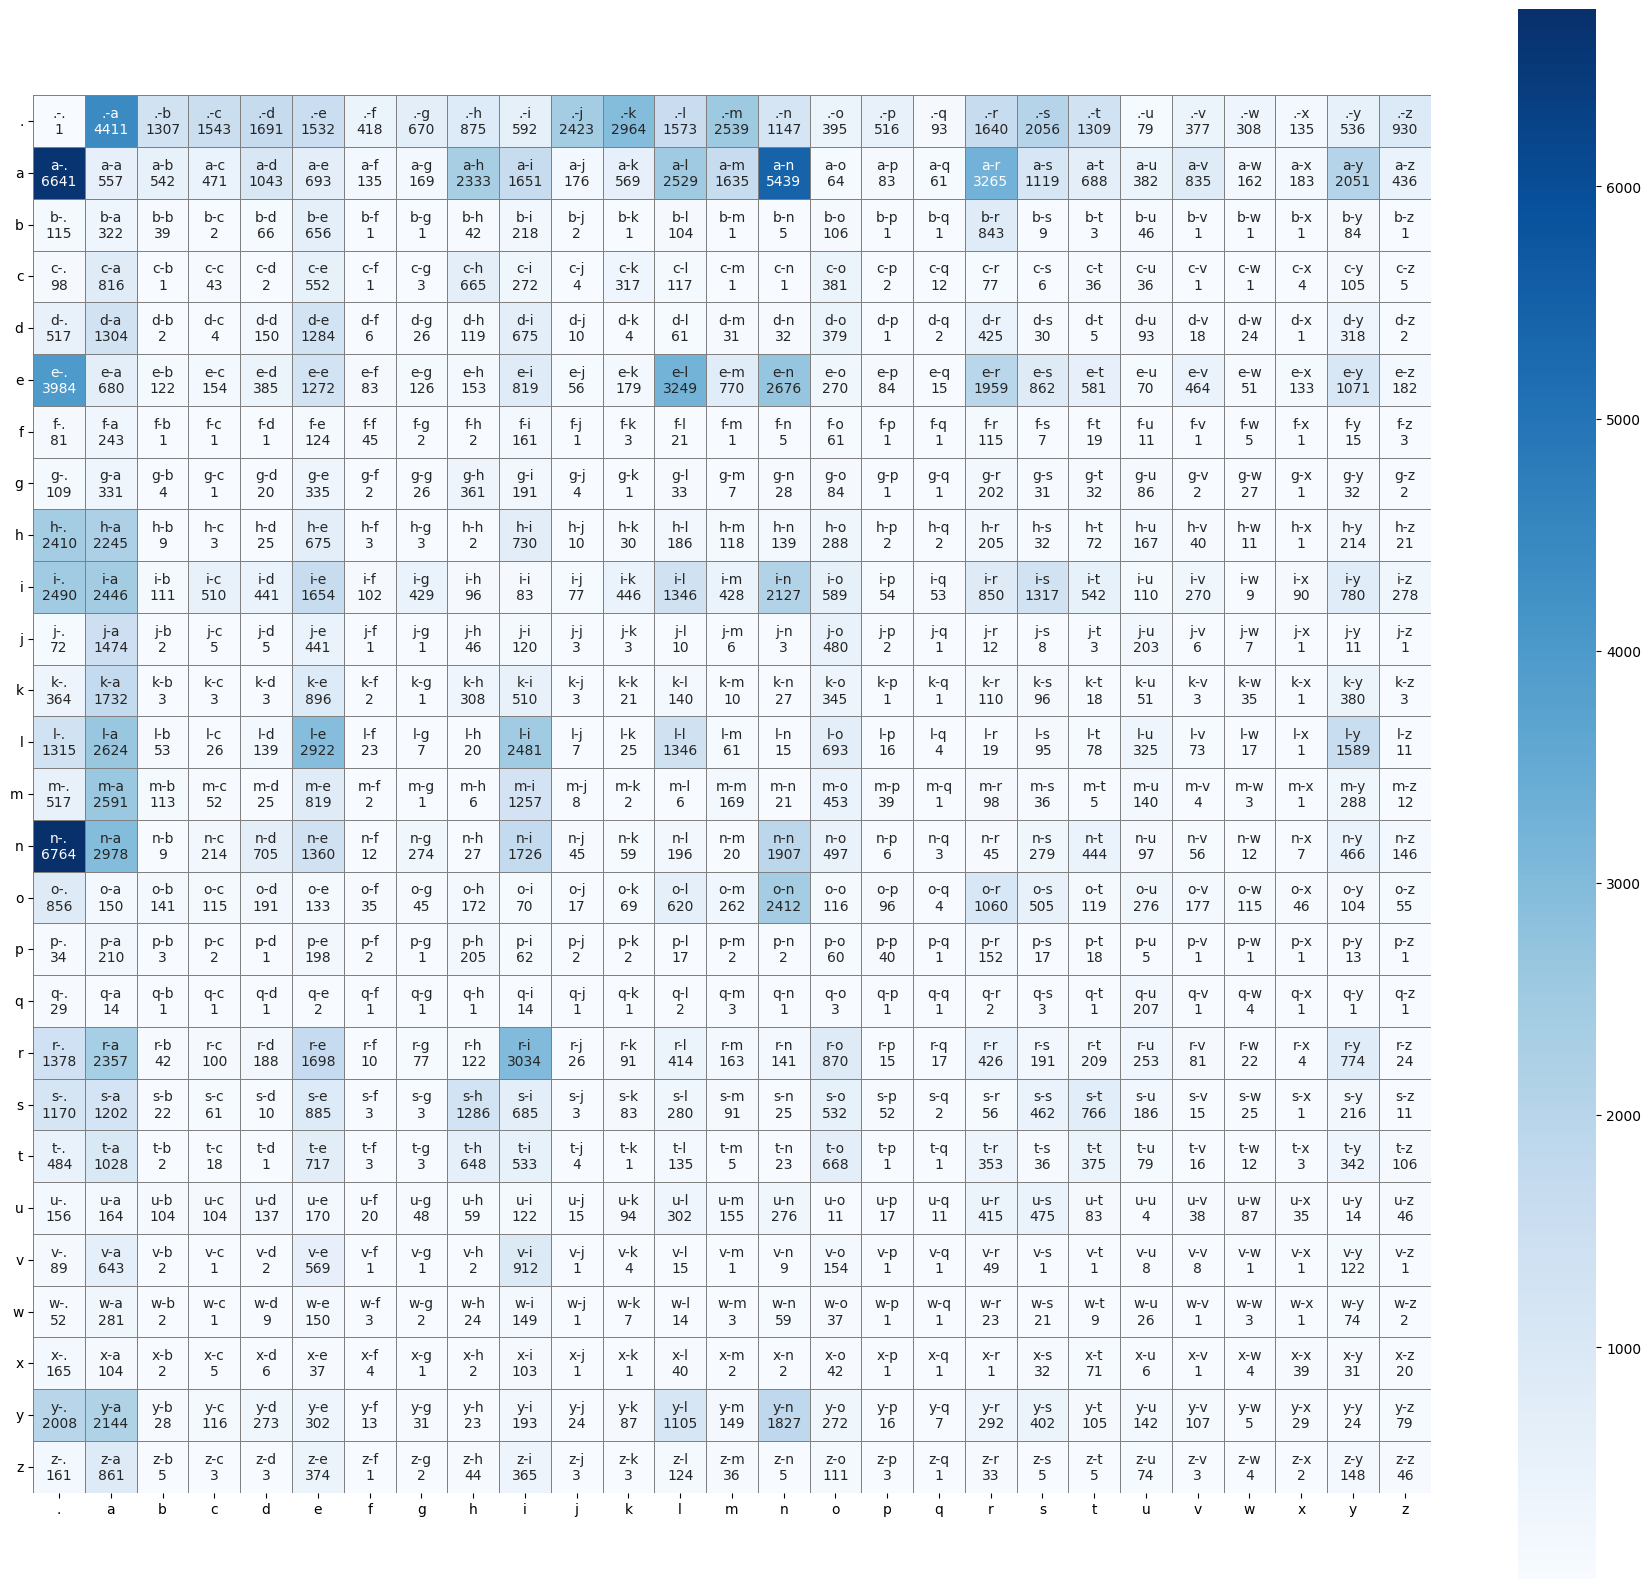

In [12]:
import pandas as pd
df = pd.DataFrame(N, index=stoi.keys(), columns=stoi.keys())

plt.figure(figsize=(18,16))
sns.heatmap(df, annot=annot, fmt="", cmap='Blues', cbar=True, linewidths=0.5, linecolor='gray', square=True)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [13]:
N.sum(dim=1, keepdim=True).shape

torch.Size([27, 1])

In [14]:
P = N / N.sum(dim=1, keepdim=True)
# P.sum(dim=1, keepdim=True)

In [15]:
torch.multinomial(P[0], num_samples=10, replacement=True)

tensor([19, 20,  4,  8,  7, 11,  4,  5, 19,  3])

In [16]:
for _ in range(5):
    ix = 0
    out = []
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

jubrindah.
cr.
fli.
keynozlovin.
cee.


In [17]:
# evaluation of the generation

In [18]:
likelihood = 1
log_likelihood = 0
n = 0
for w in words:
    chs = ['.']+list(w)+['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1, ix2 = stoi[ch1], stoi[ch2]
        n += 1
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        # print(f'bigram ({ch1} {ch2}): prob = {prob:.5f}')
        # likelihood *= prob
        log_likelihood += logprob

nll = - log_likelihood / n
print(f'{nll.item()=}')

nll.item()=2.4543561935424805


In [19]:
n=0
log_likelihood = 0
chs = ['.']+list('mrigankg')+['.']

for ch1, ch2 in zip(chs, chs[1:]):
    ix1, ix2 = stoi[ch1], stoi[ch2]
    n += 1
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    print(f'bigram ({ch1} {ch2}): prob = {prob:.5f} | logprob = {logprob:.4f}')
    # likelihood *= prob
    log_likelihood += logprob
nll = - log_likelihood / n
print()
print(f'{nll = }')

bigram (. m): prob = 0.07920 | logprob = -2.5358
bigram (m r): prob = 0.01469 | logprob = -4.2203
bigram (r i): prob = 0.23839 | logprob = -1.4338
bigram (i g): prob = 0.02420 | logprob = -3.7214
bigram (g a): prob = 0.16940 | logprob = -1.7755
bigram (a n): prob = 0.16039 | logprob = -1.8302
bigram (n k): prob = 0.00321 | logprob = -5.7401
bigram (k g): prob = 0.00020 | logprob = -8.5305
bigram (g .): prob = 0.05578 | logprob = -2.8863

nll = tensor(3.6304)


# Neural network

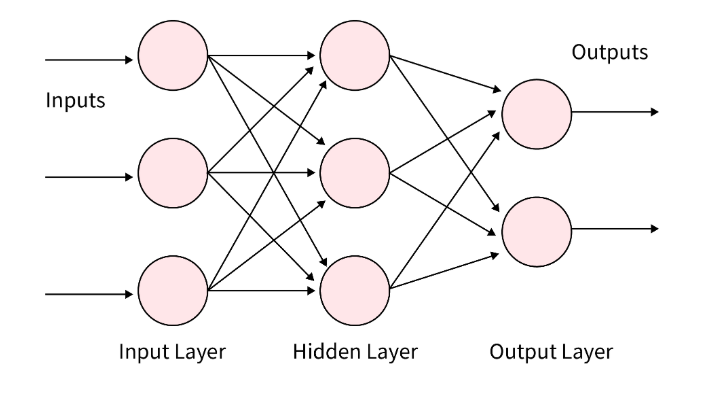

In [46]:
# build data
x = []
y = []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs[:-1], chs[1:]):
        # print(f'{ch1} - {ch2}')
        ix1, ix2 = stoi[ch1], stoi[ch2]
        x.append(ix1)
        y.append(ix2)
x = torch.tensor(x)
y = torch.tensor(y)

In [47]:
x.shape, y.shape

(torch.Size([228146]), torch.Size([228146]))

In [48]:
# x

In [49]:
# y

In [50]:
import torch.nn.functional as F

xenc = F.one_hot(x, num_classes=vocab_size).float() # (5, 27)
xenc.shape

torch.Size([228146, 27])

In [42]:
# (5,27) @ (27, 27) -> (5,27)

In [53]:
W = torch.randn((27, 27), requires_grad=True)

In [54]:
for i in range(100):
    n_samples = xenc.shape[0]

    # forward pass
    logits = xenc @ W
    counts = logits.exp()
    prob = counts / counts.sum(1, keepdim=True) # (5,27)

    # calculate loss
    loss = - prob[torch.arange(n_samples), y].log().mean() # negative log-likelihood
    if i % 10 == 0 or i == 0:
        print(f'loss = {loss:.4f}')

    # backward pass
    W.grad = None
    loss.backward()

    # weight update
    W.data += - 50 * W.grad

loss = 3.8691
loss = 2.6850
loss = 2.5724
loss = 2.5333
loss = 2.5122
loss = 2.4995
loss = 2.4911
loss = 2.4851
loss = 2.4807
loss = 2.4772


### Sampling names from learned model

In [57]:
for _ in range(5):
    ix = 0
    out = []
    while True:
        x = F.one_hot(torch.tensor([ix]), num_classes=27).float() # (1,27)
        logits = x @ W # (1,27) @ (27,27) -> (1,27)
        counts = logits.exp() # (1,27)
        prob = counts / counts.sum(1, keepdim=True) # (1,27)

        ix = torch.multinomial(prob, num_samples=1, replacement=True).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

roriayam.
grirr.
alavaniriann.
beetediygo.
vgilyn.


# Random generations

In [28]:
P = torch.ones((27,27), dtype=torch.float64) * (1/27)

In [58]:
for _ in range(5):
    ix = 0
    out = []
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

veaigxgkvxglrsmosuqjg.
cgpbdbzvyeuxblyskairuxwpkynyybmvdiizmbaenezfsyphsauufwczksczvoyitjajtefuxqmyoedyxvxhryghgeycdadnkiaa.
wjldmuvolgizaz.
culghfyiidaasdkeddjjnvpwyznbprzjicwwill.
iuiigaxcbjwexwzrbvhupqncqdyqisdlnxyotegxfswulndilevgeqljphwzkmwpuunaiurtkatcxocdknxrxtmkfzdteuqia.
